**1 Project Overview**
In this project, we will explore a dataset containing sales data to predict revenue per customer using a neural network model. The data is sourced from Google Merchandise Store.

**2 Import Libraries**
Importing these libraries serves several essential purposes in data analysis and modeling:

In [2]:
import os
import json
import numpy as np
import pandas as pd
from pandas import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

#import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import model_selection, preprocessing, metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

2024-02-21 11:35:24.560269: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.



**3 Data Preparation**
First, we will load the data and perform an initial exploration to understand its structure and content.

**Dataset Overview:**

This dataset comprises two primary files:

1. **train.csv**
2. **test.csv**

Each row within these datasets corresponds to a single visit made to the store. Our primary objective is to predict the natural logarithm of the total transaction value for each user.

**Key Data Fields:**

1. **fullVisitorId:** A distinct identifier for every Google Merchandise Store user.
2. **channelGrouping:** Indicates the medium through which the user accessed the store.
3. **date:** Specifies the date of the user's store visit.
4. **device:** Contains specifications about the device used by the visitor to access the store.
5. **geoNetwork:** Offers geographical information about the user.
6. **sessionId:** Provides a unique identifier for each store visit.
7. **socialEngagementType:** Denotes the type of user engagement, categorized as either "Socially Engaged" or "Not Socially Engaged."
8. **totals:** Contains aggregated values stemming from each session.
9. **trafficSource:** Presents information regarding the session's traffic source.
10. **visitId:** Serves as an identifier for each session. It is typically part of the value stored in the _utmb cookie. This identifier is unique to each user. For an entirely unique ID, a combination of fullVisitorId and visitId is recommended.
11. **visitNumber:** Signifies the session number for each user, with a value of 1 indicating the user's initial session.
12. **visitStartTime:** Records the timestamp, represented in POSIX time, marking the commencement of the session.




**4 Load the CSV dataset** It's important to note that certain fields are structured in JSON format, and we need to convert all the json fields in the file to a flattened csv format. It achieves by parse each JSON column into a separate DataFrame (column_as_df), rename its columns to include the original column name as a prefix, drop the original JSON column from the DataFrame, and merge the parsed DataFrame back into the original DataFrame (df), resulting in a DataFrame ready for analysis and modeling.

In [5]:
def load_df(csv_path='/Users/macbookpro/Desktop/lxc/git/Revenue-Radar/Data/train.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'},
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

train_df = load_df()
# test_df = load_df("/Users/macbookpro/Desktop/lxc/git/Revenue-Radar/Data/train.csv")

train_df.head()


Loaded train.csv. Shape: (903653, 55)


,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserVersion,device.browserSize,device.operatingSystem,device.operatingSystemVersion,device.isMobile,device.mobileDeviceBranding,device.mobileDeviceModel,device.mobileInputSelector,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.flashVersion,device.language,device.screenColors,device.screenResolution,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.cityId,geoNetwork.networkDomain,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.networkLocation,totals.visits,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.isTrueDirect,trafficSource.referralPath,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adContent,trafficSource.campaignCode
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Asia,Western Asia,Turkey,Izmir,(not set),Izmir,not available in demo dataset,ttnet.com.tr,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Oceania,Australasia,Australia,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,dodo.net.au,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Europe,Southern Europe,Spain,Community of Madrid,(not set),Madrid,not available in demo dataset,unknown.unknown,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,not available in demo dataset,Linux,not available in demo dataset,False,not ava

**5 Data Investigation** First we can see there's several features in the training set contain null values. Let's compile a list of these features, excluding columns with missing values, as well as those columns have constant values (same values, usually won't give much imformation) throughout the dataset. 
Also, for sessionId (A unique identifier for this visit to the store) can be removed since it doesn't give any information.



In [11]:
# get the list of the columns
print(train_df.columns)

Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId',
       'socialEngagementType', 'visitId', 'visitNumber', 'visitStartTime',
       'device.browser', 'device.browserVersion', 'device.browserSize',
       'device.operatingSystem', 'device.operatingSystemVersion',
       'device.isMobile', 'device.mobileDeviceBranding',
       'device.mobileDeviceModel', 'device.mobileInputSelector',
       'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName',
       'device.flashVersion', 'device.language', 'device.screenColors',
       'device.screenResolution', 'device.deviceCategory',
       'geoNetwork.continent', 'geoNetwork.subContinent', 'geoNetwork.country',
       'geoNetwork.region', 'geoNetwork.metro', 'geoNetwork.city',
       'geoNetwork.cityId', 'geoNetwork.networkDomain', 'geoNetwork.latitude',
       'geoNetwork.longitude', 'geoNetwork.networkLocation', 'totals.visits',
       'totals.hits', 'totals.pageviews', 'totals.bounces', 'totals.newVisits',
       'totals.t

In [ ]:
# get the list of the columns that rows include:"not available in demo dataset"
print(train_df.columns[train_df.isin(["not available in demo dataset"]).all()])

In [ ]:
#check the precentage of missing values
missing_values = train_df.isnull().sum()
missing_values = missing_values[missing_values > 0]
missing_values = missing_values / train_df.shape[0]
missing_values.sort_values(inplace=True)
missing_values.plot.bar()



In [6]:
null = []
for n in train_df.columns:
    if train_df[n].nunique(dropna=False) == 1:
        null.append(n)

null

['socialEngagementType',
 'device.browserVersion',
 'device.browserSize',
 'device.operatingSystemVersion',
 'device.mobileDeviceBranding',
 'device.mobileDeviceModel',
 'device.mobileInputSelector',
 'device.mobileDeviceInfo',
 'device.mobileDeviceMarketingName',
 'device.flashVersion',
 'device.language',
 'device.screenColors',
 'device.screenResolution',
 'geoNetwork.cityId',
 'geoNetwork.latitude',
 'geoNetwork.longitude',
 'geoNetwork.networkLocation',
 'totals.visits',
 'trafficSource.adwordsClickInfo.criteriaParameters']

In [14]:
columns_to_drop = null + ['sessionId']
train_df.drop(columns=columns_to_drop, inplace=True)
train_df.head()

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.networkDomain,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.isTrueDirect,trafficSource.referralPath,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adContent,trafficSource.campaignCode
0,Organic Search,20160902,1131660440785968503,1472830385,1,1472830385,Chrome,Windows,False,desktop,Asia,Western Asia,Turkey,Izmir,(not set),Izmir,ttnet.com.tr,1,1,1,1,NaN,(not set),google,organic,(not provided),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Organic Search,20160902,377306020877927890,1472880147,1,1472880147,Firefox,Macintosh,False,desktop,Oceania,Australasia,Australia,not available in demo dataset,not available in demo dataset,not available in demo dataset,dodo.net.au,1,1,1,1,NaN,(not set),google,organic,(not provided),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Organic Search,20160902,3895546263509774583,1472865386,1,1472865386,Chrome,Windows,False,desktop,Europe,Southern Europe,Spain,Community of Madrid,(not set),Madrid,unknown.unknown,1,1,1,1,NaN,(not set),google,organic,(not provided),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Organic Search,20160902,4763447161404445595,1472881213,1,1472881213,UC Browser,Linux,False,desktop,Asia,Southeast Asia,Indonesia,not available in demo dataset,not available in demo dataset,not available in demo dataset,unknown.unknown,1,1,1,1,NaN,(not set),google,organic,google + online,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Organic Search,20160902,27294437909732085,1472822600,2,1472822600,Chrome,Android,True,mobile,Europe,Northern Europe,United Kingdom,not available in demo dataset,not available in demo dataset,not available in demo dataset,unknown.unknown,1,1,1,NaN,NaN,(not set),google,organic,(not provided),True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Then for the rest of the data:** 

In [15]:
import itertools

columns = sorted(train_df.columns.tolist())
grouped_columns = [list(group) for key, group in itertools.groupby(columns, lambda x: x[0])]

for group in grouped_columns:
    print(", ".join(group))


channelGrouping
date, device.browser, device.deviceCategory, device.isMobile, device.operatingSystem
fullVisitorId
geoNetwork.city, geoNetwork.continent, geoNetwork.country, geoNetwork.metro, geoNetwork.networkDomain, geoNetwork.region, geoNetwork.subContinent
totals.bounces, totals.hits, totals.newVisits, totals.pageviews, totals.transactionRevenue, trafficSource.adContent, trafficSource.adwordsClickInfo.adNetworkType, trafficSource.adwordsClickInfo.gclId, trafficSource.adwordsClickInfo.isVideoAd, trafficSource.adwordsClickInfo.page, trafficSource.adwordsClickInfo.slot, trafficSource.campaign, trafficSource.campaignCode, trafficSource.isTrueDirect, trafficSource.keyword, trafficSource.medium, trafficSource.referralPath, trafficSource.source
visitId, visitNumber, visitStartTime


**1）.We'll prove the 80/20 rule: for many businesses–only a small percentage of customers produce most of the revenue.**

In [16]:
import numpy as np
import pandas as pd

gdf = train_df.groupby("fullVisitorId")["totals.transactionRevenue"].sum().reset_index()

gdf["totals.transactionRevenue"] = pd.to_numeric(gdf["totals.transactionRevenue"], errors="coerce")

gdf = gdf.dropna(subset=["totals.transactionRevenue"])

gdf["totals.transactionRevenue"] = np.sort(gdf["totals.transactionRevenue"])

total_customers = gdf.shape[0]
revenue_customers = gdf[gdf["totals.transactionRevenue"] > 0].shape[0]
percentage_revenue_customers = (revenue_customers / total_customers) * 100

print("Percentage of customers producing revenue: {:.2f}%".format(percentage_revenue_customers))


Percentage of customers producing revenue: 1.40%


**2）.We will exam the following for their potential impact on revenue:**

**(1)device-related data**(device.browser, device.deviceCategory, device.isMobile, device.operatingSystem)

**(2)geoNetwork-related data** (geoNetwork.city, geoNetwork.continent, geoNetwork.country, geoNetwork.metro, geoNetwork.networkDomain, geoNetwork.region, geoNetwork.subContinent)

**(3)traffic source-related data**(trafficSource.adContent, trafficSource.adwordsClickInfo.adNetworkType, trafficSource.adwordsClickInfo.gclId, trafficSource.adwordsClickInfo.isVideoAd, trafficSource.adwordsClickInfo.page, trafficSource.adwordsClickInfo.slot, trafficSource.campaign, trafficSource.campaignCode, trafficSource.isTrueDirect, trafficSource.keyword, trafficSource.medium, trafficSource.referralPath, trafficSource.source)

**(4)visitor engagement metrics**(totals.bounces, totals.hits, totals.newVisits, totals.pageviews, totals.transactionRevenue） 


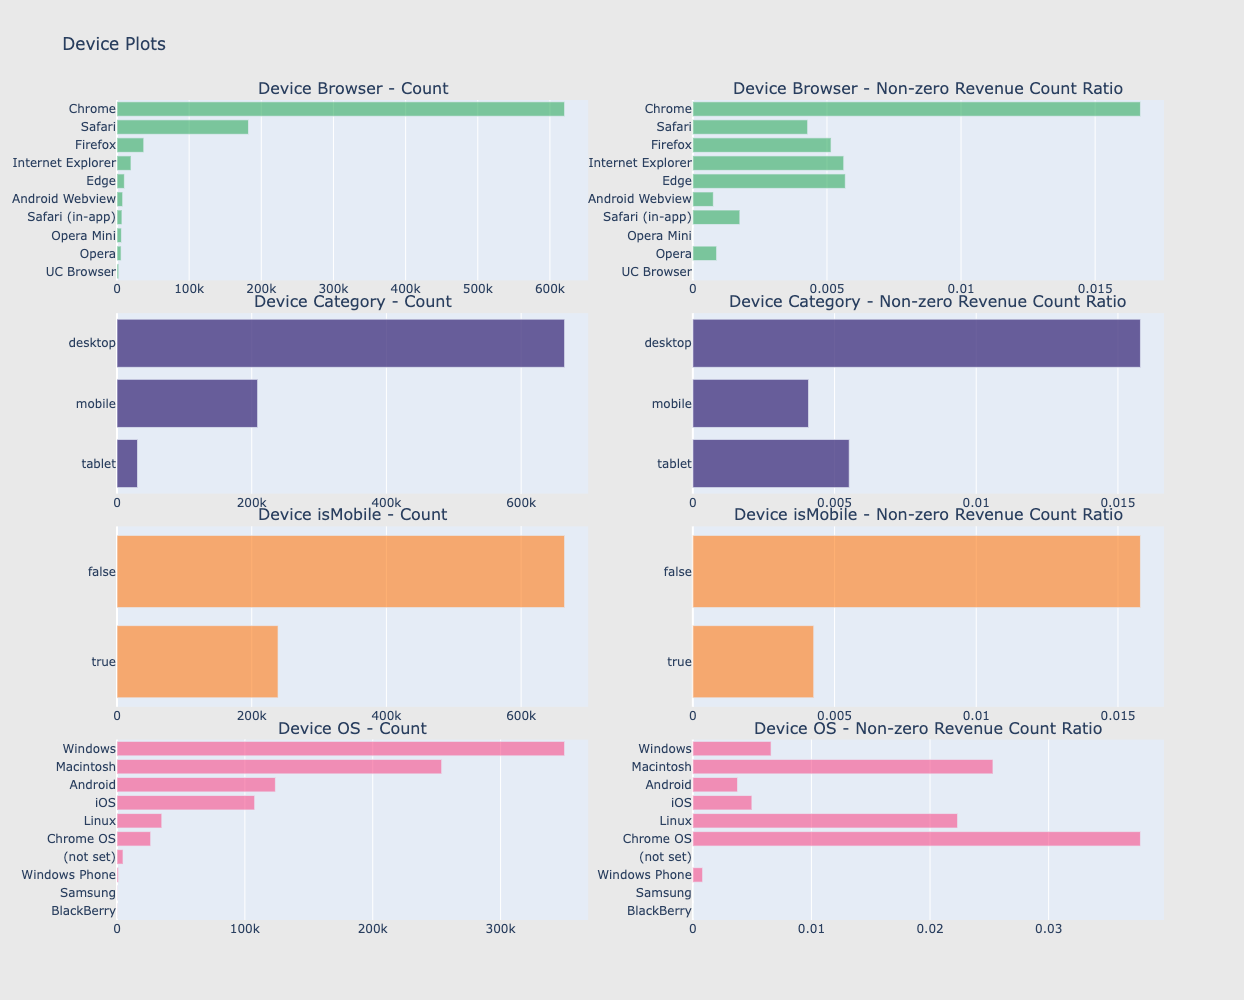

In [17]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.offline as py

train_df['totals.transactionRevenue'] = pd.to_numeric(train_df['totals.transactionRevenue'], errors='coerce')

def horizontal_bar_chart(cnt_srs, color):
    trace = go.Bar(
        y=cnt_srs.index[::-1],
        x=cnt_srs.values[::-1],
        showlegend=False,
        orientation='h',
        marker=dict(
            color=color,
        ),
    )
    return trace

# Device Browser
cnt_srs_browser = train_df.groupby('device.browser')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs_browser.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs_browser = cnt_srs_browser.sort_values(by="count", ascending=False)
trace1 = horizontal_bar_chart(cnt_srs_browser["count"].head(10), 'rgba(50, 171, 96, 0.6)')
trace2 = horizontal_bar_chart(cnt_srs_browser["count of non-zero revenue"].head(10) / cnt_srs_browser["count"].head(10), 'rgba(50, 171, 96, 0.6)')

# Device Category
cnt_srs_category = train_df.groupby('device.deviceCategory')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs_category.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs_category = cnt_srs_category.sort_values(by="count", ascending=False)
trace3 = horizontal_bar_chart(cnt_srs_category["count"].head(10), 'rgba(71, 58, 131, 0.8)')
trace4 = horizontal_bar_chart(cnt_srs_category["count of non-zero revenue"].head(10) / cnt_srs_category["count"].head(10), 'rgba(71, 58, 131, 0.8)')

# Device isMobile
cnt_srs_is_mobile = train_df.groupby('device.isMobile')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs_is_mobile.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs_is_mobile = cnt_srs_is_mobile.sort_values(by="count", ascending=False)
trace5 = horizontal_bar_chart(cnt_srs_is_mobile["count"].head(10), 'rgba(255, 123, 22, 0.6)')
trace6 = horizontal_bar_chart(cnt_srs_is_mobile["count of non-zero revenue"].head(10) / cnt_srs_is_mobile["count"].head(10), 'rgba(255, 123, 22, 0.6)')

# Operating system
cnt_srs_os = train_df.groupby('device.operatingSystem')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs_os.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs_os = cnt_srs_os.sort_values(by="count", ascending=False)
trace7 = horizontal_bar_chart(cnt_srs_os["count"].head(10), 'rgba(246, 78, 139, 0.6)')
trace8 = horizontal_bar_chart(cnt_srs_os["count of non-zero revenue"].head(10) / cnt_srs_os["count"].head(10), 'rgba(246, 78, 139, 0.6)')

# Creating a subplot with 4 rows and 2 columns
fig = make_subplots(rows=4, cols=2, vertical_spacing=0.04, 
                    subplot_titles=["Device Browser - Count", "Device Browser - Non-zero Revenue Count Ratio",
                                    "Device Category - Count",  "Device Category - Non-zero Revenue Count Ratio",
                                    "Device isMobile - Count", "Device isMobile - Non-zero Revenue Count Ratio",
                                    "Device OS - Count", "Device OS - Non-zero Revenue Count Ratio"])

# Adding traces to the subplot
fig.add_trace(trace1, row=1, col=1)
fig.add_trace(trace2, row=1, col=2)
fig.add_trace(trace3, row=2, col=1)
fig.add_trace(trace4, row=2, col=2)
fig.add_trace(trace5, row=3, col=1)
fig.add_trace(trace6, row=3, col=2)
fig.add_trace(trace7, row=4, col=1)
fig.add_trace(trace8, row=4, col=2)

# Updating layout
fig.update_layout(height=1000, width=1000, paper_bgcolor='rgb(233,233,233)', title="Device Plots")

# Displaying the plot
py.iplot(fig, filename='device-plots')


from device-related data we see:

1.Device browser: Chrome has higher percentage of non-zero revenue counts.

2.Device category: desktop has higher percentage of non-zero revenue counts.

3.No-mobile has higher percentage of non-zero revenue counts.

4.Chrome OS has higher percentage of non-zero revenue counts.


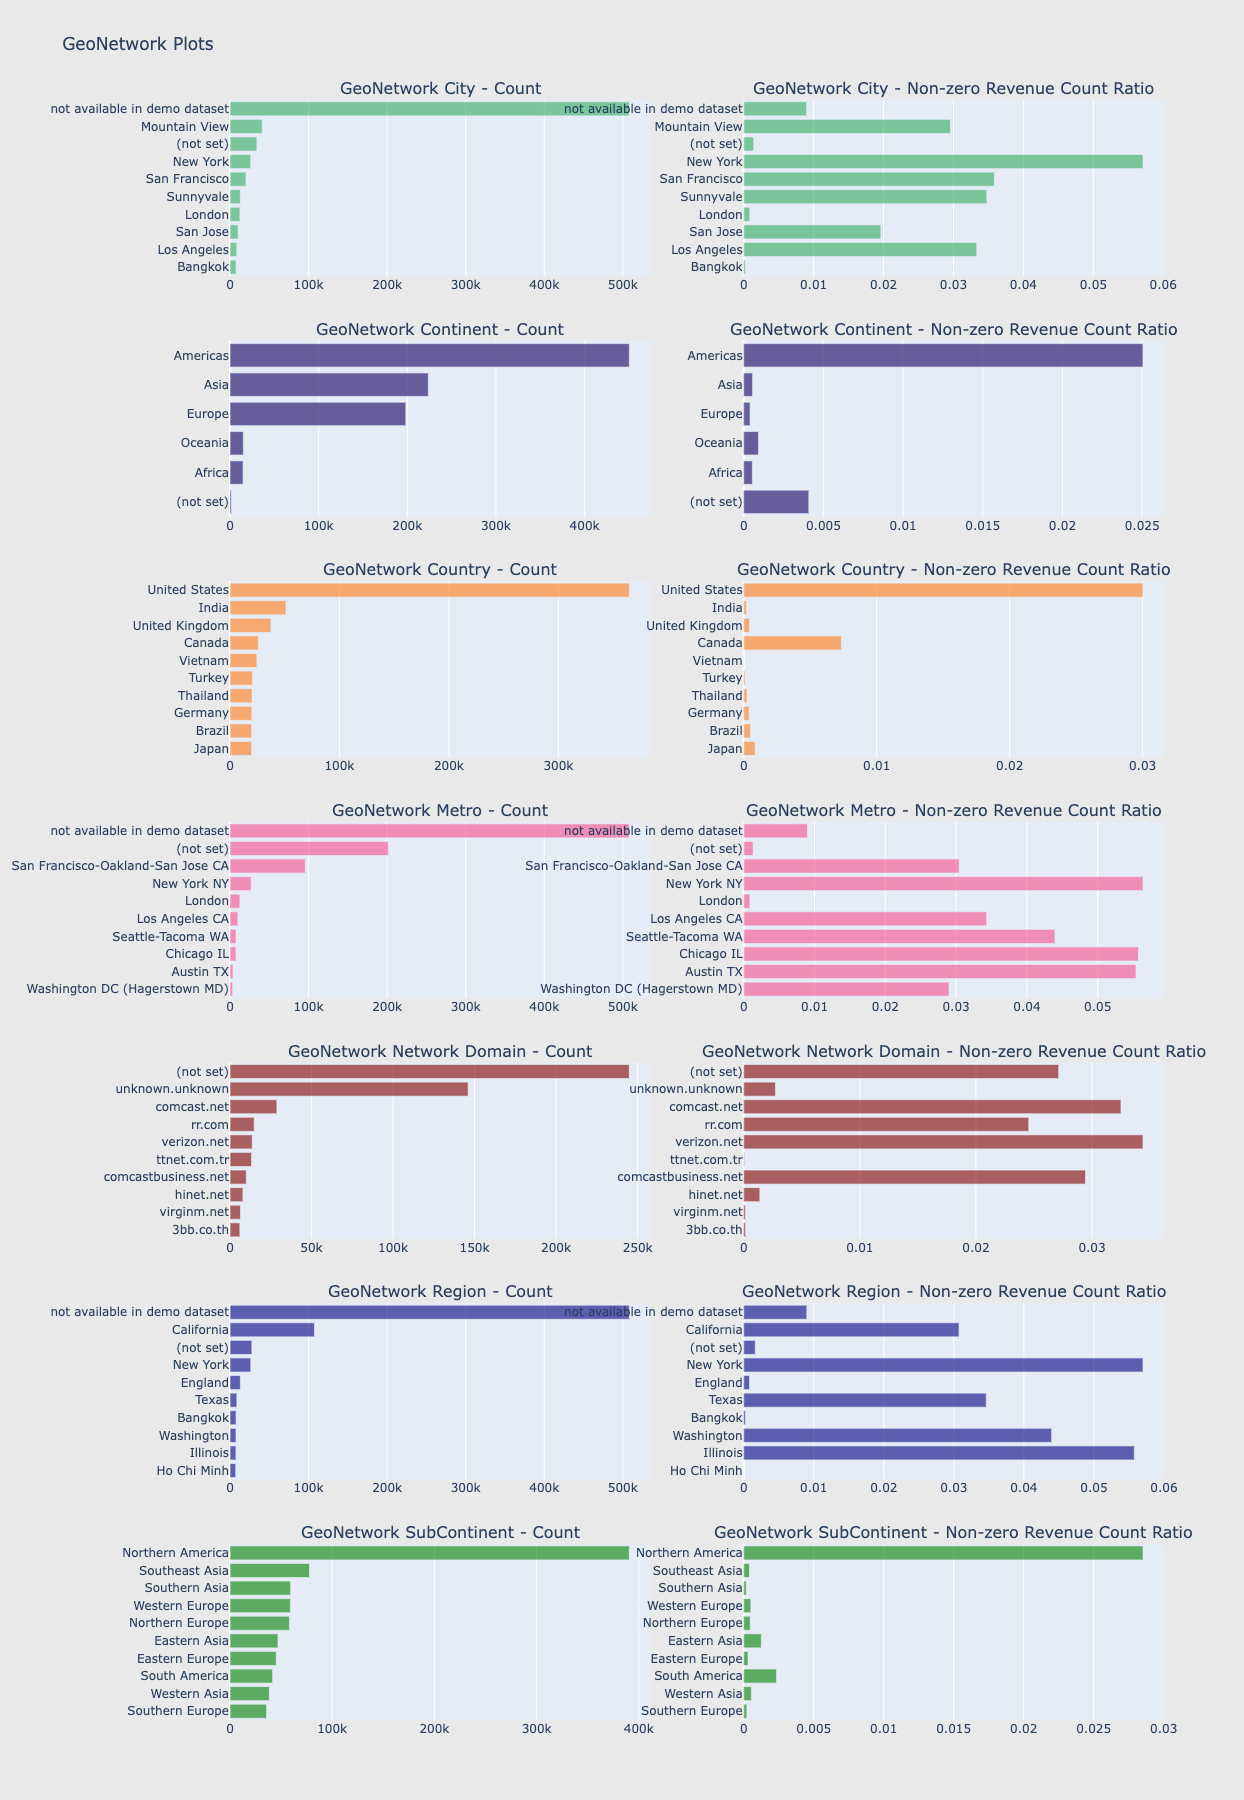

In [18]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.offline as py

def horizontal_bar_chart(cnt_srs, color):
    trace = go.Bar(
        y=cnt_srs.index[::-1],
        x=cnt_srs.values[::-1],
        showlegend=False,
        orientation='h',
        marker=dict(
            color=color,
        ),
    )
    return trace

# GeoNetwork City
cnt_srs_city = train_df.groupby('geoNetwork.city')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs_city.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs_city = cnt_srs_city.sort_values(by="count", ascending=False)
trace1 = horizontal_bar_chart(cnt_srs_city["count"].head(10), 'rgba(50, 171, 96, 0.6)')
trace2 = horizontal_bar_chart(cnt_srs_city["count of non-zero revenue"].head(10) / cnt_srs_city["count"].head(10), 'rgba(50, 171, 96, 0.6)')

# GeoNetwork Continent
cnt_srs_continent = train_df.groupby('geoNetwork.continent')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs_continent.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs_continent = cnt_srs_continent.sort_values(by="count", ascending=False)
trace3 = horizontal_bar_chart(cnt_srs_continent["count"].head(10), 'rgba(71, 58, 131, 0.8)')
trace4 = horizontal_bar_chart(cnt_srs_continent["count of non-zero revenue"].head(10) / cnt_srs_continent["count"].head(10), 'rgba(71, 58, 131, 0.8)')

# GeoNetwork Country
cnt_srs_country = train_df.groupby('geoNetwork.country')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs_country.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs_country = cnt_srs_country.sort_values(by="count", ascending=False)
trace5 = horizontal_bar_chart(cnt_srs_country["count"].head(10), 'rgba(255, 123, 22, 0.6)')
trace6 = horizontal_bar_chart(cnt_srs_country["count of non-zero revenue"].head(10) / cnt_srs_country["count"].head(10), 'rgba(255, 123, 22, 0.6)')

# GeoNetwork Metro
cnt_srs_metro = train_df.groupby('geoNetwork.metro')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs_metro.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs_metro = cnt_srs_metro.sort_values(by="count", ascending=False)
trace7 = horizontal_bar_chart(cnt_srs_metro["count"].head(10), 'rgba(246, 78, 139, 0.6)')
trace8 = horizontal_bar_chart(cnt_srs_metro["count of non-zero revenue"].head(10) / cnt_srs_metro["count"].head(10), 'rgba(246, 78, 139, 0.6)')

# GeoNetwork Network Domain
cnt_srs_network_domain = train_df.groupby('geoNetwork.networkDomain')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs_network_domain.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs_network_domain = cnt_srs_network_domain.sort_values(by="count", ascending=False)
trace9 = horizontal_bar_chart(cnt_srs_network_domain["count"].head(10), 'rgba(128, 0, 0, 0.6)')
trace10 = horizontal_bar_chart(cnt_srs_network_domain["count of non-zero revenue"].head(10) / cnt_srs_network_domain["count"].head(10), 'rgba(128, 0, 0, 0.6)')

# GeoNetwork Region
cnt_srs_region = train_df.groupby('geoNetwork.region')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs_region.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs_region = cnt_srs_region.sort_values(by="count", ascending=False)
trace11 = horizontal_bar_chart(cnt_srs_region["count"].head(10), 'rgba(0, 0, 128, 0.6)')
trace12 = horizontal_bar_chart(cnt_srs_region["count of non-zero revenue"].head(10) / cnt_srs_region["count"].head(10), 'rgba(0, 0, 128, 0.6)')

# GeoNetwork SubContinent
cnt_srs_subcontinent = train_df.groupby('geoNetwork.subContinent')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs_subcontinent.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs_subcontinent = cnt_srs_subcontinent.sort_values(by="count", ascending=False)
trace13 = horizontal_bar_chart(cnt_srs_subcontinent["count"].head(10), 'rgba(0, 128, 0, 0.6)')
trace14 = horizontal_bar_chart(cnt_srs_subcontinent["count of non-zero revenue"].head(10) / cnt_srs_subcontinent["count"].head(10), 'rgba(0, 128, 0, 0.6)')

# Creating a subplot with 7 rows and 2 columns
fig = make_subplots(rows=7, cols=2, vertical_spacing=0.04, 
                    subplot_titles=["GeoNetwork City - Count", "GeoNetwork City - Non-zero Revenue Count Ratio",
                                    "GeoNetwork Continent - Count",  "GeoNetwork Continent - Non-zero Revenue Count Ratio",
                                    "GeoNetwork Country - Count", "GeoNetwork Country - Non-zero Revenue Count Ratio",
                                    "GeoNetwork Metro - Count", "GeoNetwork Metro - Non-zero Revenue Count Ratio",
                                    "GeoNetwork Network Domain - Count", "GeoNetwork Network Domain - Non-zero Revenue Count Ratio",
                                    "GeoNetwork Region - Count", "GeoNetwork Region - Non-zero Revenue Count Ratio",
                                    "GeoNetwork SubContinent - Count", "GeoNetwork SubContinent - Non-zero Revenue Count Ratio"])

# Adding traces to the subplot
fig.add_trace(trace1, row=1, col=1)
fig.add_trace(trace2, row=1, col=2)
fig.add_trace(trace3, row=2, col=1)
fig.add_trace(trace4, row=2, col=2)
fig.add_trace(trace5, row=3, col=1)
fig.add_trace(trace6, row=3, col=2)
fig.add_trace(trace7, row=4, col=1)
fig.add_trace(trace8, row=4, col=2)
fig.add_trace(trace9, row=5, col=1)
fig.add_trace(trace10, row=5, col=2)
fig.add_trace(trace11, row=6, col=1)
fig.add_trace(trace12, row=6, col=2)
fig.add_trace(trace13, row=7, col=1)
fig.add_trace(trace14, row=7, col=2)

# Updating layout
fig.update_layout(height=1800, width=1000, paper_bgcolor='rgb(233,233,233)', title="GeoNetwork Plots")

# Displaying the plot
py.iplot(fig, filename='geonetwork-plots')


from geoNetwork-related data we see:

1.City: New York has higher percentage of non-zero revenue counts.

2.Continent: we can see that America has both higher number of counts as well as highest percentage of non-zero revenue counts. Though Asia and Europe has high number of counts, the percentage of non-zero revenue counts from these continents are comparatively low.

3.If the network domain is "unknown.unknown" rather than "(not set)", then the number of counts with non-zero revenue tend to be lower.





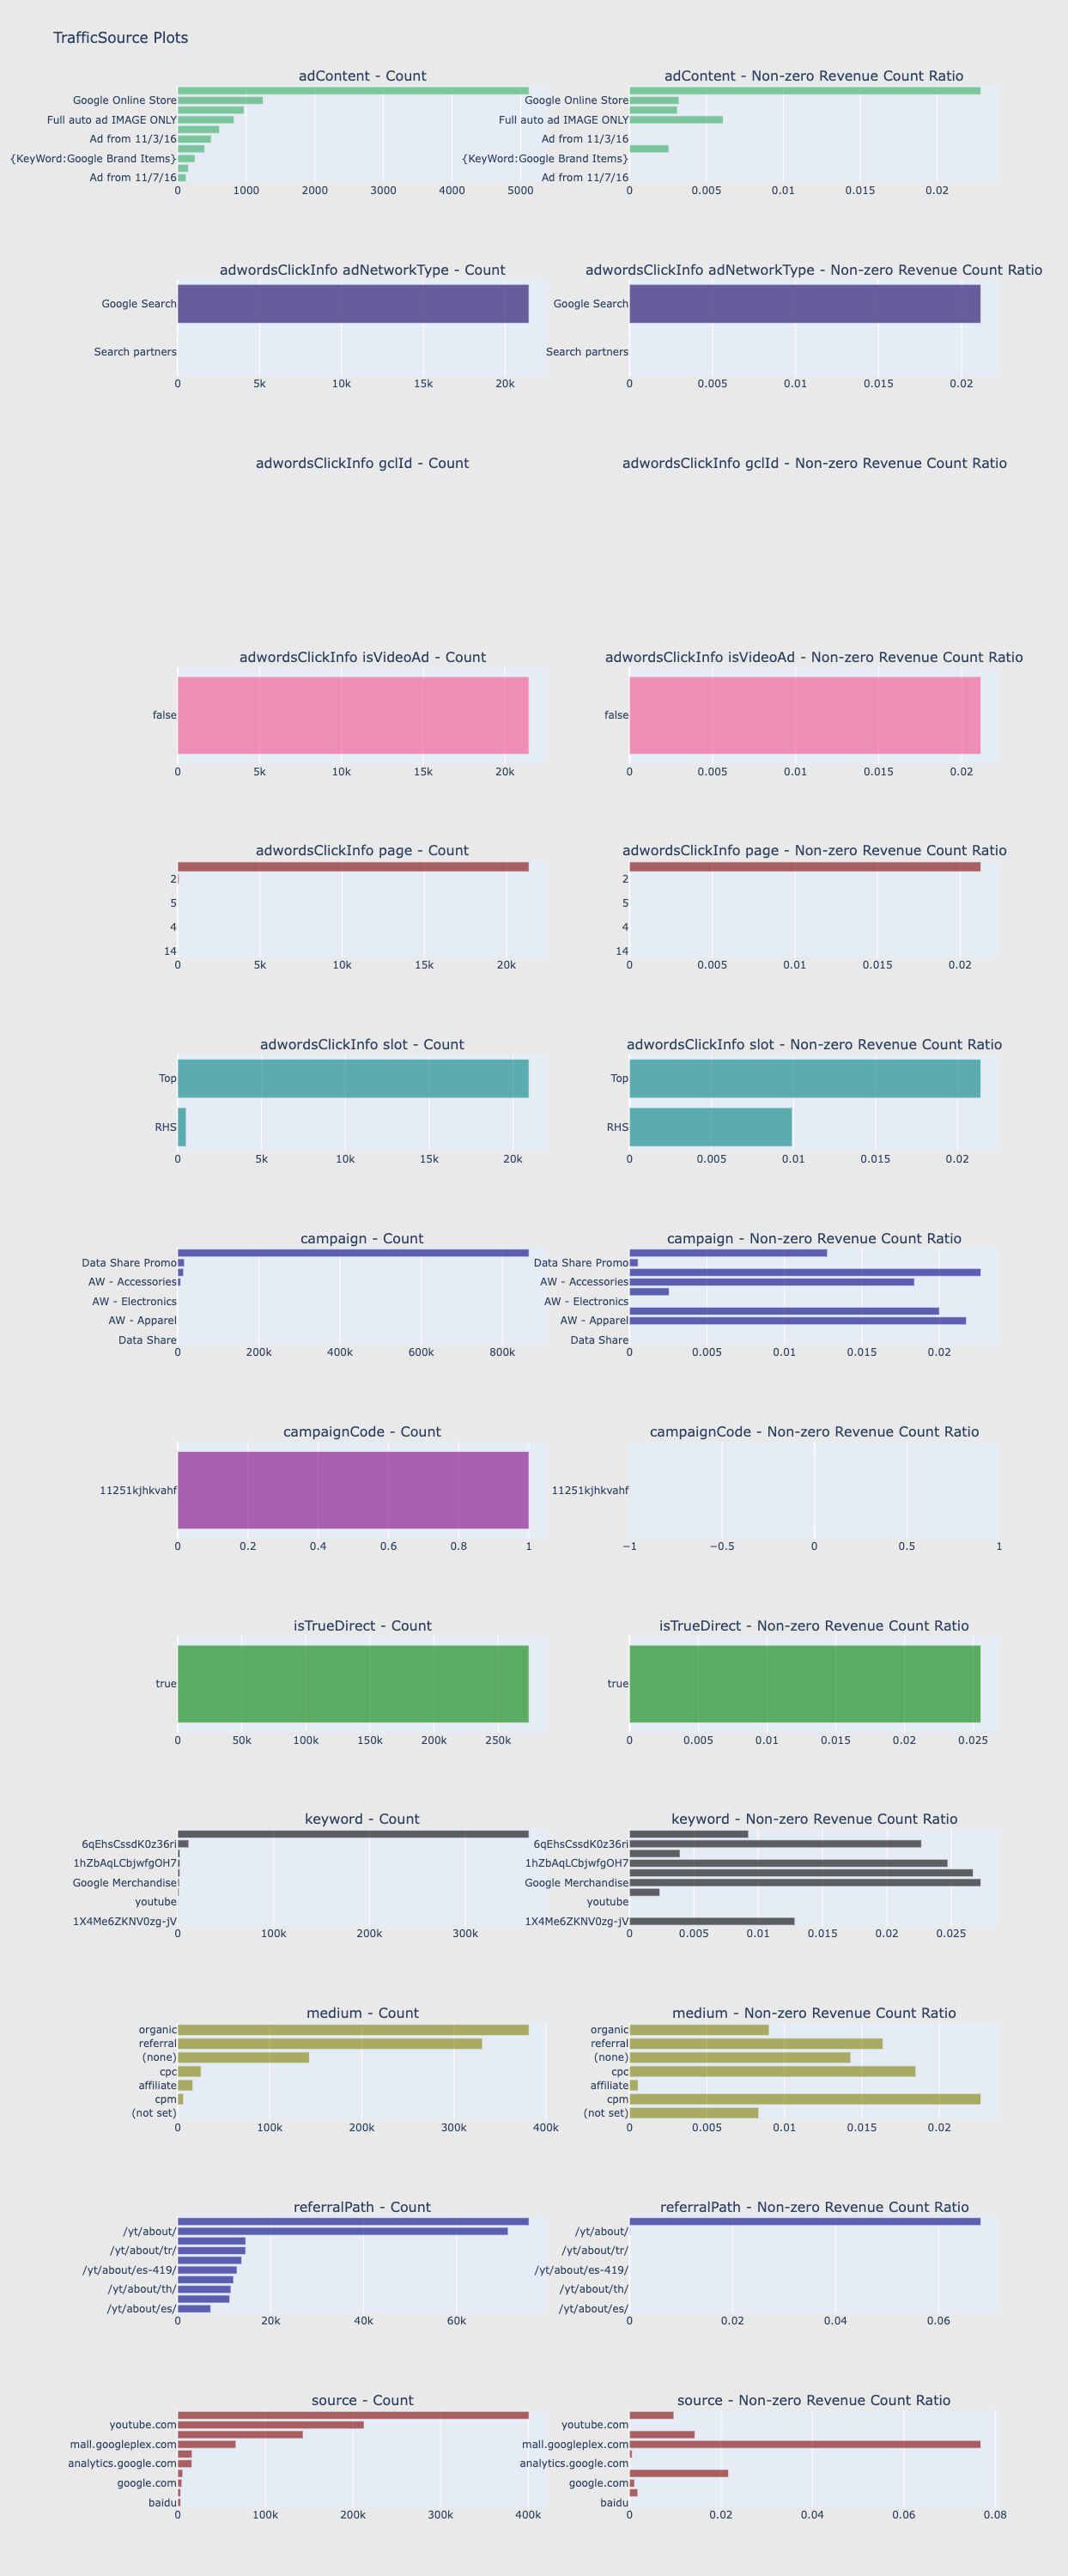

In [19]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.offline as py

def horizontal_bar_chart(cnt_srs, color):
    trace = go.Bar(
        y=cnt_srs.index[::-1],
        x=cnt_srs.values[::-1],
        showlegend=False,
        orientation='h',
        marker=dict(
            color=color,
        ),
    )
    return trace

# TrafficSource adContent
cnt_srs_adcontent = train_df.groupby('trafficSource.adContent')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs_adcontent.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs_adcontent = cnt_srs_adcontent.sort_values(by="count", ascending=False)
trace1 = horizontal_bar_chart(cnt_srs_adcontent["count"].head(10), 'rgba(50, 171, 96, 0.6)')
trace2 = horizontal_bar_chart(cnt_srs_adcontent["count of non-zero revenue"].head(10) / cnt_srs_adcontent["count"].head(10), 'rgba(50, 171, 96, 0.6)')

# TrafficSource adwordsClickInfo adNetworkType
cnt_srs_adnetworktype = train_df.groupby('trafficSource.adwordsClickInfo.adNetworkType')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs_adnetworktype.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs_adnetworktype = cnt_srs_adnetworktype.sort_values(by="count", ascending=False)
trace3 = horizontal_bar_chart(cnt_srs_adnetworktype["count"].head(10), 'rgba(71, 58, 131, 0.8)')
trace4 = horizontal_bar_chart(cnt_srs_adnetworktype["count of non-zero revenue"].head(10) / cnt_srs_adnetworktype["count"].head(10), 'rgba(71, 58, 131, 0.8)')

# TrafficSource adwordsClickInfo gclId
cnt_srs_gclid = train_df.groupby('trafficSource.adwordsClickInfo.gclId')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs_gclid.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs_gclid = cnt_srs_gclid.sort_values(by="count", ascending=False)
trace5 = horizontal_bar_chart(cnt_srs_gclid["count"].head(10), 'rgba(255, 123, 22, 0.6)')
trace6 = horizontal_bar_chart(cnt_srs_gclid["count of non-zero revenue"].head(10) / cnt_srs_gclid["count"].head(10), 'rgba(255, 123, 22, 0.6)')

# TrafficSource adwordsClickInfo isVideoAd
cnt_srs_isvideoad = train_df.groupby('trafficSource.adwordsClickInfo.isVideoAd')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs_isvideoad.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs_isvideoad = cnt_srs_isvideoad.sort_values(by="count", ascending=False)
trace7 = horizontal_bar_chart(cnt_srs_isvideoad["count"].head(10), 'rgba(246, 78, 139, 0.6)')
trace8 = horizontal_bar_chart(cnt_srs_isvideoad["count of non-zero revenue"].head(10) / cnt_srs_isvideoad["count"].head(10), 'rgba(246, 78, 139, 0.6)')

# TrafficSource adwordsClickInfo page
cnt_srs_adpage = train_df.groupby('trafficSource.adwordsClickInfo.page')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs_adpage.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs_adpage = cnt_srs_adpage.sort_values(by="count", ascending=False)
trace9 = horizontal_bar_chart(cnt_srs_adpage["count"].head(10), 'rgba(128, 0, 0, 0.6)')
trace10 = horizontal_bar_chart(cnt_srs_adpage["count of non-zero revenue"].head(10) / cnt_srs_adpage["count"].head(10), 'rgba(128, 0, 0, 0.6)')

# TrafficSource adwordsClickInfo slot
cnt_srs_adslot = train_df.groupby('trafficSource.adwordsClickInfo.slot')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs_adslot.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs_adslot = cnt_srs_adslot.sort_values(by="count", ascending=False)
trace11 = horizontal_bar_chart(cnt_srs_adslot["count"].head(10), 'rgba(0, 128, 128, 0.6)')
trace12 = horizontal_bar_chart(cnt_srs_adslot["count of non-zero revenue"].head(10) / cnt_srs_adslot["count"].head(10), 'rgba(0, 128, 128, 0.6)')

# TrafficSource campaign
cnt_srs_campaign = train_df.groupby('trafficSource.campaign')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs_campaign.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs_campaign = cnt_srs_campaign.sort_values(by="count", ascending=False)
trace13 = horizontal_bar_chart(cnt_srs_campaign["count"].head(10), 'rgba(0, 0, 128, 0.6)')
trace14 = horizontal_bar_chart(cnt_srs_campaign["count of non-zero revenue"].head(10) / cnt_srs_campaign["count"].head(10), 'rgba(0, 0, 128, 0.6)')

# TrafficSource campaignCode
cnt_srs_campaigncode = train_df.groupby('trafficSource.campaignCode')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs_campaigncode.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs_campaigncode = cnt_srs_campaigncode.sort_values(by="count", ascending=False)
trace15 = horizontal_bar_chart(cnt_srs_campaigncode["count"].head(10), 'rgba(128, 0, 128, 0.6)')
trace16 = horizontal_bar_chart(cnt_srs_campaigncode["count of non-zero revenue"].head(10) / cnt_srs_campaigncode["count"].head(10), 'rgba(128, 0, 128, 0.6)')

# TrafficSource isTrueDirect
cnt_srs_istrue = train_df.groupby('trafficSource.isTrueDirect')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs_istrue.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs_istrue = cnt_srs_istrue.sort_values(by="count", ascending=False)
trace17 = horizontal_bar_chart(cnt_srs_istrue["count"].head(10), 'rgba(0, 128, 0, 0.6)')
trace18 = horizontal_bar_chart(cnt_srs_istrue["count of non-zero revenue"].head(10) / cnt_srs_istrue["count"].head(10), 'rgba(0, 128, 0, 0.6)')

# TrafficSource keyword
cnt_srs_keyword = train_df.groupby('trafficSource.keyword')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs_keyword.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs_keyword = cnt_srs_keyword.sort_values(by="count", ascending=False)
trace19 = horizontal_bar_chart(cnt_srs_keyword["count"].head(10), 'rgba(0, 0, 0, 0.6)')
trace20 = horizontal_bar_chart(cnt_srs_keyword["count of non-zero revenue"].head(10) / cnt_srs_keyword["count"].head(10), 'rgba(0, 0, 0, 0.6)')

# TrafficSource medium
cnt_srs_medium = train_df.groupby('trafficSource.medium')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs_medium.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs_medium = cnt_srs_medium.sort_values(by="count", ascending=False)
trace21 = horizontal_bar_chart(cnt_srs_medium["count"].head(10), 'rgba(128, 128, 0, 0.6)')
trace22 = horizontal_bar_chart(cnt_srs_medium["count of non-zero revenue"].head(10) / cnt_srs_medium["count"].head(10), 'rgba(128, 128, 0, 0.6)')

# TrafficSource referralPath
cnt_srs_referral = train_df.groupby('trafficSource.referralPath')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs_referral.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs_referral = cnt_srs_referral.sort_values(by="count", ascending=False)
trace23 = horizontal_bar_chart(cnt_srs_referral["count"].head(10), 'rgba(0, 0, 128, 0.6)')
trace24 = horizontal_bar_chart(cnt_srs_referral["count of non-zero revenue"].head(10) / cnt_srs_referral["count"].head(10), 'rgba(0, 0, 128, 0.6)')

# TrafficSource source
cnt_srs_source = train_df.groupby('trafficSource.source')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs_source.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs_source = cnt_srs_source.sort_values(by="count", ascending=False)
trace25 = horizontal_bar_chart(cnt_srs_source["count"].head(10), 'rgba(128, 0, 0, 0.6)')
trace26 = horizontal_bar_chart(cnt_srs_source["count of non-zero revenue"].head(10) / cnt_srs_source["count"].head(10), 'rgba(128, 0, 0, 0.6)')

# Creating a subplot with 13 rows and 2 columns
fig = make_subplots(rows=13, cols=2, vertical_spacing=0.04, 
                    subplot_titles=["adContent - Count", "adContent - Non-zero Revenue Count Ratio",
                                    "adwordsClickInfo adNetworkType - Count", "adwordsClickInfo adNetworkType - Non-zero Revenue Count Ratio",
                                    "adwordsClickInfo gclId - Count", "adwordsClickInfo gclId - Non-zero Revenue Count Ratio",
                                    "adwordsClickInfo isVideoAd - Count", "adwordsClickInfo isVideoAd - Non-zero Revenue Count Ratio",
                                    "adwordsClickInfo page - Count", "adwordsClickInfo page - Non-zero Revenue Count Ratio",
                                    "adwordsClickInfo slot - Count", "adwordsClickInfo slot - Non-zero Revenue Count Ratio",
                                    "campaign - Count", "campaign - Non-zero Revenue Count Ratio",
                                    "campaignCode - Count", "campaignCode - Non-zero Revenue Count Ratio",
                                    "isTrueDirect - Count", "isTrueDirect - Non-zero Revenue Count Ratio",
                                    "keyword - Count", "keyword - Non-zero Revenue Count Ratio",
                                    "medium - Count", "medium - Non-zero Revenue Count Ratio",
                                    "referralPath - Count", "referralPath - Non-zero Revenue Count Ratio",
                                    "source - Count", "source - Non-zero Revenue Count Ratio"])

# Adding traces to the subplot
fig.add_trace(trace1, row=1, col=1)
fig.add_trace(trace2, row=1, col=2)
fig.add_trace(trace3, row=2, col=1)
fig.add_trace(trace4, row=2, col=2)
#fig.add_trace(trace5, row=3, col=1)
#fig.add_trace(trace6, row=3, col=2)
fig.add_trace(trace7, row=4, col=1)
fig.add_trace(trace8, row=4, col=2)
fig.add_trace(trace9, row=5, col=1)
fig.add_trace(trace10, row=5, col=2)
fig.add_trace(trace11, row=6, col=1)
fig.add_trace(trace12, row=6, col=2)
fig.add_trace(trace13, row=7, col=1)
fig.add_trace(trace14, row=7, col=2)
fig.add_trace(trace15, row=8, col=1)
fig.add_trace(trace16, row=8, col=2)
fig.add_trace(trace17, row=9, col=1)
fig.add_trace(trace18, row=9, col=2)
fig.add_trace(trace19, row=10, col=1)
fig.add_trace(trace20, row=10, col=2)
fig.add_trace(trace21, row=11, col=1)
fig.add_trace(trace22, row=11, col=2)
fig.add_trace(trace23, row=12, col=1)
fig.add_trace(trace24, row=12, col=2)
fig.add_trace(trace25, row=13, col=1)
fig.add_trace(trace26, row=13, col=2)

# Updating layout
fig.update_layout(height=3000, width=1200, paper_bgcolor='rgb(233,233,233)', title="TrafficSource Plots")

# Displaying the plot
py.iplot(fig, filename='trafficsource-plots')


In the traffic source analysis, it's notable that while YouTube appears frequently in the dataset, the instances where it contributes to non-zero revenue are quite rare.

On the other hand, Google Plex stands out with a significantly high ratio of non-zero revenue counts compared to its overall count in the traffic source plot.

When examining traffic source mediums, it's interesting to observe that the "referral" medium exhibits a greater number of non-zero revenue counts compared to the "organic" medium.

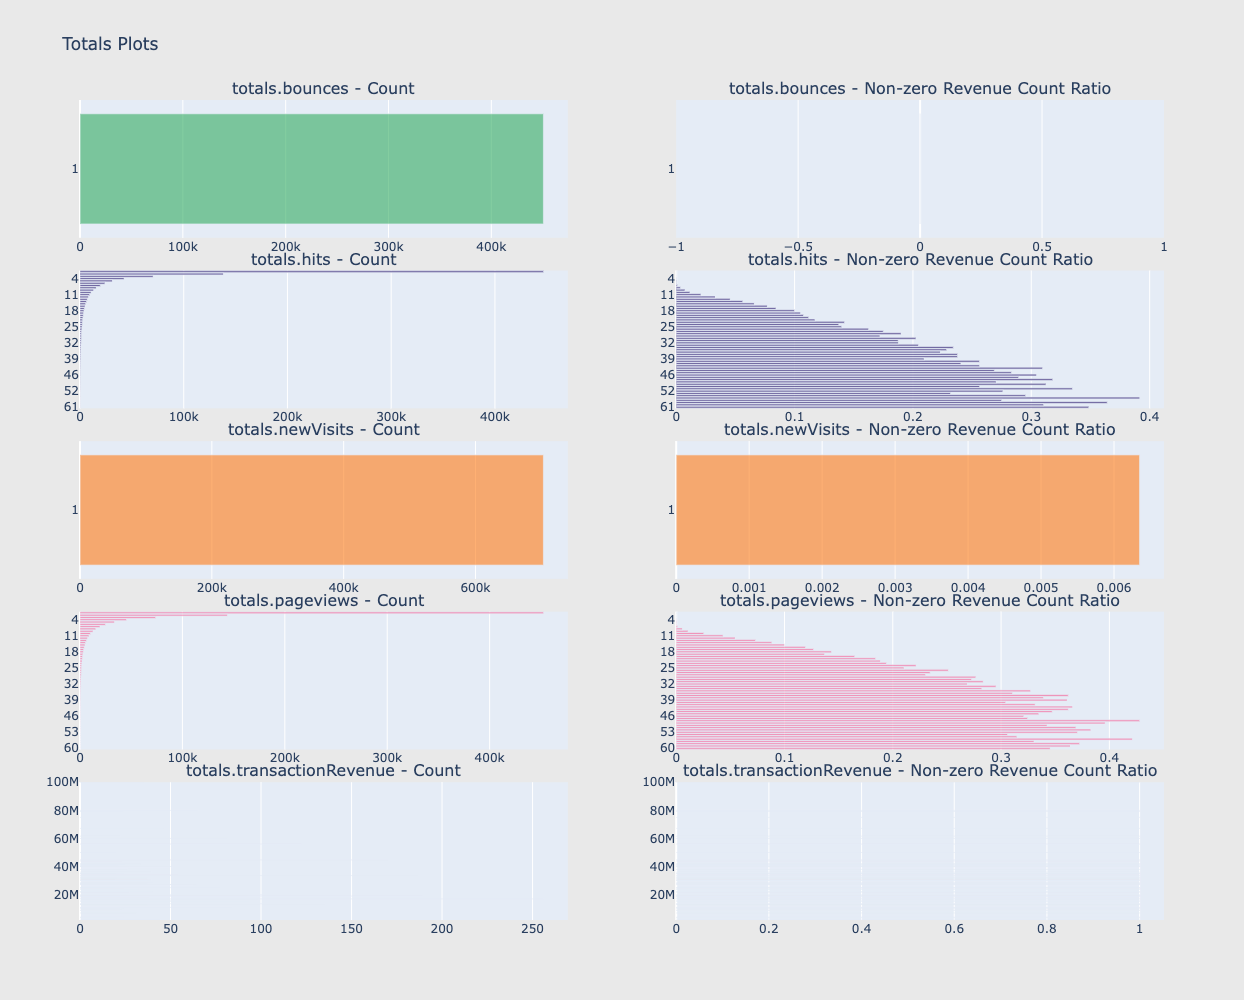

In [20]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.offline as py

def horizontal_bar_chart(cnt_srs, color):
    trace = go.Bar(
        y=cnt_srs.index[::-1],
        x=cnt_srs.values[::-1],
        showlegend=False,
        orientation='h',
        marker=dict(
            color=color,
        ),
    )
    return trace

# totals.bounces
cnt_srs_bounces = train_df.groupby('totals.bounces')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs_bounces.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs_bounces = cnt_srs_bounces.sort_values(by="count", ascending=False)
trace1 = horizontal_bar_chart(cnt_srs_bounces["count"].head(60), 'rgba(50, 171, 96, 0.6)')
trace2 = horizontal_bar_chart(cnt_srs_bounces["count of non-zero revenue"].head(60) / cnt_srs_bounces["count"].head(60), 'rgba(50, 171, 96, 0.6)')

# totals.hits
cnt_srs_hits = train_df.groupby('totals.hits')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs_hits.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs_hits = cnt_srs_hits.sort_values(by="count", ascending=False)
trace3 = horizontal_bar_chart(cnt_srs_hits["count"].head(60), 'rgba(71, 58, 131, 0.8)')
trace4 = horizontal_bar_chart(cnt_srs_hits["count of non-zero revenue"].head(60) / cnt_srs_hits["count"].head(60), 'rgba(71, 58, 131, 0.8)')

# totals.newVisits
cnt_srs_newVisits = train_df.groupby('totals.newVisits')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs_newVisits.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs_newVisits = cnt_srs_newVisits.sort_values(by="count", ascending=False)
trace5 = horizontal_bar_chart(cnt_srs_newVisits["count"].head(60), 'rgba(255, 123, 22, 0.6)')
trace6 = horizontal_bar_chart(cnt_srs_newVisits["count of non-zero revenue"].head(60) / cnt_srs_newVisits["count"].head(60), 'rgba(255, 123, 22, 0.6)')

# totals.pageviews
cnt_srs_pageviews = train_df.groupby('totals.pageviews')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs_pageviews.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs_pageviews = cnt_srs_pageviews.sort_values(by="count", ascending=False)
trace7 = horizontal_bar_chart(cnt_srs_pageviews["count"].head(60), 'rgba(246, 78, 139, 0.6)')
trace8 = horizontal_bar_chart(cnt_srs_pageviews["count of non-zero revenue"].head(60) / cnt_srs_pageviews["count"].head(60), 'rgba(246, 78, 139, 0.6)')

# totals.transactionRevenue
cnt_srs_revenue = train_df.groupby('totals.transactionRevenue')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs_revenue.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs_revenue = cnt_srs_revenue.sort_values(by="count", ascending=False)
trace9 = horizontal_bar_chart(cnt_srs_revenue["count"].head(60), 'rgba(0, 128, 128, 0.6)')
trace10 = horizontal_bar_chart(cnt_srs_revenue["count of non-zero revenue"].head(60) / cnt_srs_revenue["count"].head(60), 'rgba(0, 128, 128, 0.6)')

# Creating a subplot with 5 rows and 2 columns
fig = make_subplots(rows=5, cols=2, vertical_spacing=0.04, 
                    subplot_titles=["totals.bounces - Count", "totals.bounces - Non-zero Revenue Count Ratio",
                                    "totals.hits - Count", "totals.hits - Non-zero Revenue Count Ratio",
                                    "totals.newVisits - Count", "totals.newVisits - Non-zero Revenue Count Ratio",
                                    "totals.pageviews - Count", "totals.pageviews - Non-zero Revenue Count Ratio",
                                    "totals.transactionRevenue - Count", "totals.transactionRevenue - Non-zero Revenue Count Ratio"])

# Adding traces to the subplot
fig.add_trace(trace1, row=1, col=1)
fig.add_trace(trace2, row=1, col=2)
fig.add_trace(trace3, row=2, col=1)
fig.add_trace(trace4, row=2, col=2)
fig.add_trace(trace5, row=3, col=1)
fig.add_trace(trace6, row=3, col=2)
fig.add_trace(trace7, row=4, col=1)
fig.add_trace(trace8, row=4, col=2)
fig.add_trace(trace9, row=5, col=1)
fig.add_trace(trace10, row=5, col=2)

# Updating layout
fig.update_layout(height=1000, width=900, paper_bgcolor='rgb(233,233,233)', title="Totals Plots")

# Displaying the plot
py.iplot(fig, filename='totals-plots')


As the number of hits or pageviews per visitor transaction increases, we observe a significant rise in the ratio of non-zero revenue occurrences.

**6. Baseline Model:**

Now let us build a baseline model on this dataset. Before we start building models, let us look at the variable names which are there in train dataset and not in test dataset.

In [21]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import datetime

train_df['date'] = pd.to_datetime(train_df['date'], format='%Y%m%d')

# Impute 0 for missing target values
train_df["totals.transactionRevenue"].fillna(0, inplace=True)
train_y = train_df["totals.transactionRevenue"].values
train_id = train_df["fullVisitorId"].values
test_id = test_df["fullVisitorId"].values

# label encode the categorical variables and convert the numerical variables to float
cat_cols = ["channelGrouping", "device.browser", 
            "device.deviceCategory", "device.operatingSystem", 
            "geoNetwork.city", "geoNetwork.continent", 
            "geoNetwork.country", "geoNetwork.metro",
            "geoNetwork.networkDomain", "geoNetwork.region", 
            "geoNetwork.subContinent", "trafficSource.adContent", 
            "trafficSource.adwordsClickInfo.adNetworkType", 
            "trafficSource.adwordsClickInfo.gclId", 
            "trafficSource.adwordsClickInfo.page", 
            "trafficSource.adwordsClickInfo.slot", "trafficSource.campaign",
            "trafficSource.keyword", "trafficSource.medium", 
            "trafficSource.referralPath", "trafficSource.source",
            'trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.isTrueDirect']
for col in cat_cols:
    print(col)
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(train_df[col].values.astype('str')) + list(test_df[col].values.astype('str')))
    train_df[col] = lbl.transform(list(train_df[col].values.astype('str')))
    test_df[col] = lbl.transform(list(test_df[col].values.astype('str')))

num_cols = ["totals.hits", "totals.pageviews", "visitNumber", "visitStartTime", 'totals.bounces',  'totals.newVisits']    
for col in num_cols:
    train_df[col] = train_df[col].astype(float)
    test_df[col] = test_df[col].astype(float)

# Split the train dataset into development and valid based on time 
dev_df = train_df[train_df['date'] <= datetime.datetime(2017, 5, 31)]
val_df = train_df[train_df['date'] > datetime.datetime(2017, 5, 31)]
dev_y = np.log1p(dev_df["totals.transactionRevenue"].values)
val_y = np.log1p(val_df["totals.transactionRevenue"].values)

dev_X = dev_df[cat_cols + num_cols] 
val_X = val_df[cat_cols + num_cols] 
test_X = test_df[cat_cols + num_cols] 



import lightgbm as lgb
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse", 
        "num_leaves" : 30,
        "min_child_samples" : 100,
        "learning_rate" : 0.1,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.5,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    pred_val_y = model.predict(val_X, num_iteration=model.best_iteration)
    return pred_test_y, model, pred_val_y

# Training the model #
pred_test, model, pred_val = run_lgb(dev_X, dev_y, val_X, val_y, test_X)


from sklearn import metrics
pred_val[pred_val < 0] = 0
val_pred_df = pd.DataFrame({"fullVisitorId": val_df["fullVisitorId"].values})
val_pred_df["transactionRevenue"] = val_df["totals.transactionRevenue"].values
val_pred_df["PredictedRevenue"] = np.expm1(pred_val)

# RMSE
rmse = np.sqrt(metrics.mean_squared_error(np.log1p(val_pred_df["transactionRevenue"].values), np.log1p(val_pred_df["PredictedRevenue"].values)))
print("Root Mean Squared Error (RMSE):", rmse)


sub_df = pd.DataFrame({"fullVisitorId":test_id})
pred_test[pred_test<0] = 0
sub_df["PredictedLogRevenue"] = np.expm1(pred_test)
sub_df = sub_df.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()
sub_df.columns = ["fullVisitorId", "PredictedLogRevenue"]
sub_df["PredictedLogRevenue"] = np.log1p(sub_df["PredictedLogRevenue"])
sub_df.to_csv("baseline_lgb.csv", index=False)

channelGrouping
device.browser
device.deviceCategory
device.operatingSystem
geoNetwork.city
geoNetwork.continent
geoNetwork.country
geoNetwork.metro
geoNetwork.networkDomain
geoNetwork.region
geoNetwork.subContinent
trafficSource.adContent
trafficSource.adwordsClickInfo.adNetworkType
trafficSource.adwordsClickInfo.gclId
trafficSource.adwordsClickInfo.page
trafficSource.adwordsClickInfo.slot
trafficSource.campaign
trafficSource.keyword
trafficSource.medium
trafficSource.referralPath
trafficSource.source
trafficSource.adwordsClickInfo.isVideoAd
trafficSource.isTrueDirect


In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

# Loading required libraries
import pandas as pd
import numpy as np
import json
from datetime import datetime
import lightgbm as lgb
import warnings
from sklearn.model_selection import train_test_split

# Suppress warnings
warnings.filterwarnings("ignore")

# Defining types of extracted attributes
dtypes = {
    "fullVisitorId": str,
    "channelGrouping": str,
    "date": str,
    "device": str,
    "geoNetwork": str,
    "socialEngagementType": str,
    "totals": str,
    "trafficSource": str,
    "visitId": int,
    "visitNumber": int,
    "visitStartTime": int,
    "hits": str,
    "customDimensions": str
}

# Data extraction
print("Data Extraction")
tr0 = pd.read_csv('/kaggle/input/ga-customer-revenue-prediction/train.csv', dtype=dtypes)
te0 = pd.read_csv('/kaggle/input/ga-customer-revenue-prediction/train.csv', dtype=dtypes)

# Data parsing
def flatten_json(df, col_name):
    df = df.copy()
    df[col_name] = df[col_name].apply(lambda x: json.loads(x))
    df = pd.concat([df.drop([col_name], axis=1), df[col_name].apply(pd.Series)], axis=1)
    return df

print("Data Parsing")
tr0 = flatten_json(tr0, 'device')
tr0 = flatten_json(tr0, 'geoNetwork')
tr0 = flatten_json(tr0, 'trafficSource')
tr0 = flatten_json(tr0, 'totals')

# Define useful columns
#good_cols = ["channelGrouping", "date", "fullVisitorId", "visitId", "visitNumber", "visitStartTime", "browser",
 #            "deviceCategory", "isMobile", "operatingSystem", "city", "continent", "country", "metro", "networkDomain",
  #           "region", "subContinent", "bounces", "hits", "newVisits", "pageviews", "sessionQualityDim", "timeOnSite",
   #          "totalTransactionRevenue", "transactionRevenue", "transactions", "adContent", "adwordsClickInfo.adNetworkType",
    #         "adwordsClickInfo.gclId", "adwordsClickInfo.isVideoAd", "adwordsClickInfo.page", "adwordsClickInfo.slot",
     #        "campaign", "isTrueDirect", "keyword", "medium", "referralPath", "source"]
good_cols = ["channelGrouping", "device.browser", 
            "device.deviceCategory", "device.operatingSystem", 
            "geoNetwork.city", "geoNetwork.continent", 
            "geoNetwork.country", "geoNetwork.metro",
            "geoNetwork.networkDomain", "geoNetwork.region", 
            "geoNetwork.subContinent", "trafficSource.adContent", 
            "trafficSource.adwordsClickInfo.adNetworkType", 
            "trafficSource.adwordsClickInfo.gclId", 
            "trafficSource.adwordsClickInfo.page", 
            "trafficSource.adwordsClickInfo.slot", "trafficSource.campaign",
            "trafficSource.keyword", "trafficSource.medium", 
            "trafficSource.referralPath", "trafficSource.source",
            'trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.isTrueDirect']

# Combine tables and convert to dataframe
tr = tr0[good_cols].append(te0[good_cols], sort=False)
tr.reset_index(drop=True, inplace=True)

# Convert date column to datetime
tr["date"] = pd.to_datetime(tr["date"], format="%Y%m%d", errors="coerce")

# Convert columns to integers
int_cols = ["visitNumber", "visitStartTime", "bounces", "hits", "newVisits", "pageviews", "transactionRevenue", "transactions"]
tr[int_cols] = tr[int_cols].fillna(0).astype(int)

# Replace missing transactionRevenue with 0
tr["transactionRevenue"].fillna(0, inplace=True)

# Function to get time frame with features
def get_time_frame_with_features(data, k):
    tf = data[(data["date"] >= data["date"].min() + pd.DateOffset(days=168 * (k - 1))) &
              (data["date"] < data["date"].min() + pd.DateOffset(days=168 * k))].copy()
    tf_fvid = data[(data["date"] >= data["date"].min() + pd.DateOffset(days=168 * k + 46)) &
                   (data["date"] < data["date"].min() + pd.DateOffset(days=168 * k + 46 + 62))]["fullVisitorId"].unique()
    tf_returned = tf[tf["fullVisitorId"].isin(tf_fvid)].copy()
    tf_tst = data[(data["fullVisitorId"].isin(tf_returned["fullVisitorId"])) &
                   (data["date"] >= data["date"].min() + pd.DateOffset(days=168 * k + 46)) &
                   (data["date"] < data["date"].min() + pd.DateOffset(days=168 * k + 46 + 62))].copy()

    tf_target = tf_tst.groupby("fullVisitorId")["transactionRevenue"].sum().apply(lambda x: np.log1p(x))
    tf_target = tf_target.reset_index()
    tf_target.columns = ["fullVisitorId", "target"]
    tf_target["ret"] = 1

    tf_nonret = pd.DataFrame(data={"fullVisitorId": tf[~tf["fullVisitorId"].isin(tf_fvid)]["fullVisitorId"].unique(),
                                   "target": 0,
                                   "ret": 0})

    tf_target = pd.concat([tf_target, tf_nonret], sort=False)

    tf_maxdate = tf["date"].max()
    tf_mindate = tf["date"].min()

    tf = tf.groupby("fullVisitorId").agg({
        "channelGrouping": "max",
        "first_ses_from_the_period_start": lambda x: (x.min() - tf_mindate).astype(int),
        "last_ses_from_the_period_end": lambda x: (tf_maxdate - x.max()).astype(int),
        "interval_dates": lambda x: (x.max() - x.min()).astype(int),
        "unique_date_num": "nunique",
        "maxVisitNum": "max",
        "browser": "max",
        "operatingSystem": "max",
        "deviceCategory": "max",
        "continent": "max",
        "subContinent": "max",
        "country": "max",
        "region": "max",
        "metro": "max",
        "city": "max",
        "networkDomain": "max",
        "source": "max",
        "medium": "max",
        "isVideoAd_mean": lambda x: np.mean(x),
        "isMobile": lambda x: np.mean(x),
        "isTrueDirect": lambda x: np.mean(x),
        "bounce_sessions": lambda x: np.sum(x),
        "hits_sum": "sum",
        "hits_mean": "mean",
        "hits_min": "min",
        "hits_max": "max",
        "hits_median": "median",
        "hits_sd": "std",
        "pageviews_sum": "sum",
        "pageviews_mean": "mean",
        "pageviews_min": "min",
        "pageviews_max": "max",
        "pageviews_median": "median",
        "pageviews_sd": "std",
        "session_cnt": "size",
        "transactionRevenue": "sum",
        "transactions": "sum"
    }).reset_index()

    tf = tf.merge(tf_target, on="fullVisitorId", how="left")

    return tf

# Getting parts of train-set
print("Get 1st train part")
tr1 = get_time_frame_with_features(tr, 1)
print("Get 2nd train part")
tr2 = get_time_frame_with_features(tr, 2)
print("Get 3rd train part")
tr3 = get_time_frame_with_features(tr, 3)
print("Get 4th train part")
tr4 = get_time_frame_with_features(tr, 4)

# Costruction of the test-set (by analogy as train-set)
print("Get test")
tr5 = tr[tr["date"] >= '2018-05-01'].copy()
tr5_maxdate = tr5["date"].max()
tr5_mindate = tr5["date"].min()

tf = tr5.groupby("fullVisitorId").agg({
    "channelGrouping": "max",
    "first_ses_from_the_period_start": lambda x: (x.min() - tr5_mindate).astype(int),
    "last_ses_from_the_period_end": lambda x: (tr5_maxdate - x.max()).astype(int),
    "interval_dates": lambda x: (x.max() - x.min()).astype(int),
    "unique_date_num": "nunique",
    "maxVisitNum": "max",
    "browser": "max",
    "operatingSystem": "max",
    "deviceCategory": "max",
    "continent": "max",
    "subContinent": "max",
    "country": "max",
    "region": "max",
    "metro": "max",
    "city": "max",
    "networkDomain": "max",
    "source": "max",
    "medium": "max",
    "isVideoAd_mean": lambda x: np.mean(x),
    "isMobile": lambda x: np.mean(x),
    "isTrueDirect": lambda x: np.mean(x),
    "bounce_sessions": lambda x: np.sum(x),
    "hits_sum": "sum",
    "hits_mean": "mean",
    "hits_min": "min",
    "hits_max": "max",
    "hits_median": "median",
    "hits_sd": "std",
    "pageviews_sum": "sum",
    "pageviews_mean": "mean",
    "pageviews_min": "min",
    "pageviews_max": "max",
    "pageviews_median": "median",
    "pageviews_sd": "std",
    "session_cnt": "size",
    "transactionRevenue": "sum",
    "transactions": "sum"
}).reset_index()

tr5["target"] = np.nan
tr5["ret"] = np.nan
tr5 = pd.concat([tr5, tf], sort=False)

# Combine all pieces and convert the types
train_all = pd.concat([tr1, tr2, tr3, tr4, tr5], sort=False)
train_all["interval_dates"] = train_all["interval_dates"].astype(int)
train_all["last_ses_from_the_period_end"] = train_all["last_ses_from_the_period_end"].astype(int)
train_all["first_ses_from_the_period_start"] = train_all["first_ses_from_the_period_start"].astype(int)

# Filter train and test from combined dataframe
train = train_all[~train_all["target"].isna()].copy()
test = train_all[train_all["target"].isna()].copy()

# Parameters of "isReturned" classifier
param_lgb2 = {
    "objective": "binary",
    "max_bin": 256,
    "learning_rate": 0.01,
    "num_leaves": 15,
    "bagging_fraction": 0.9,
    "feature_fraction": 0.8,
    "min_data": 1,
    "bagging_freq": 1,
    "metric": "binary_logloss"
}

# Parameters of "How_Much_Returned_Will_Pay" regressor
param_lgb3 = {
    "objective": "regression",
    "max_bin": 256,
    "learning_rate": 0.01,
    "num_leaves": 9,
    "bagging_fraction": 0.9,
    "feature_fraction": 0.8,
    "min_data": 1,
    "bagging_freq": 1,
    "metric": "rmse"
}

# Training and prediction of models: Averaging of 10 [Classificator*Regressor] values
X_train = train.drop(["fullVisitorId", "ret", "target"], axis=1)
y_train = train["ret"]
X_test = test.drop(["fullVisitorId", "ret", "target"], axis=1)

pr_lgb_sum = 0
print("Training and predictions")
for i in range(10):
    print(f"Iteration number {i}")
    dtrain_all = lgb.Dataset(X_train, label=y_train)
    lgb_model1 = lgb.train(param_lgb2, dtrain_all, num_boost_round=1200)
    pr_lgb = lgb_model1.predict(X_test)

    dtrain_ret = lgb.Dataset(X_train[y_train == 1], label=train[train["ret"] == 1]["target"])
    lgb_model2 = lgb.train(param_lgb3, dtrain_ret, num_boost_round=368)
    pr_lgb_ret = lgb_model2.predict(X_test)

    pr_lgb_sum += pr_lgb * pr_lgb_ret

pr_final2 = pr_lgb_sum / 10

# Writing final predictions to CSV
submission = pd.DataFrame({
    "fullVisitorId": test["fullVisitorId"],
    "PredictedLogRevenue": pr_final2
})

submission.to_csv("tst4.csv", index=False)


Data Extraction
Data Parsing
